# Viscosity Prediction using SVR

## Flow
* Discuss data, take the statistics
* Get performance of mean predictor, why is it good?
* Get the performance of SVR,
* Check the hyperparameter optimisation
* show the decision boundary of SVR for different parameter combination
* compare performance with mean estimator
* Compare grid serach with PSO and genetic algorithm


In [60]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR as SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  KFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as MSE

In [3]:
#check the directorry for files 
! ls

deepLearning.ipynb  viscosityData.xlsx  viscosityPred.ipynb


In [4]:
#import the data 

dfData = pd.read_excel("viscosityData.xlsx")

dfData.head()

,Eta (cP),T2gm (ms),T (K),TE (ms)
0,2242.150000,2.020000,303.15,0.10
1,30724.077831,0.988897,312.15,0.24
2,6217.946533,1.467505,327.15,0.24
3,200.533942,6.199510,376.15,0.24
4,88.627484,10.880354,394.15,0.24


In [5]:
#get the statistics
dfData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Eta (cP)   282 non-null    float64
 1   T2gm (ms)  282 non-null    float64
 2   T (K)      282 non-null    float64
 3   TE (ms)    282 non-null    float64
dtypes: float64(4)
memory usage: 8.9 KB


In [6]:
#get the statisstics
dfData.describe()

,Eta (cP),T2gm (ms),T (K),TE (ms)
count,282.000000,282.000000,282.000000,282.000000
mean,12978.518683,59.386988,337.433688,0.204113
std,61373.723431,165.578141,45.158531,0.077543
min,0.871718,0.230000,299.150000,0.100000
25%,33.894908,1.790493,303.150000,0.100000
50%,416.887570,5.160508,323.150000,0.240000
75%,3509.831760,30.875000,361.900000,0.240000
max,867634.812287,1239.900000,468.150000,0.300000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94b04cfa90>,
      dtype=object)

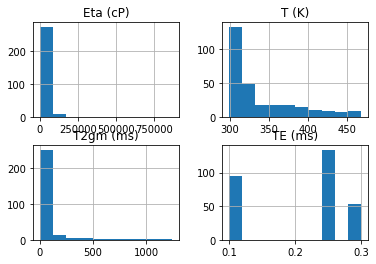

In [7]:
#get the hsitogram of variables
dfData.hist()

In [8]:
#separate predictors and target
X = dfData.iloc[:,1:]
y = dfData.iloc[:,:1]

print(X.head(),y.head())

   T2gm (ms)   T (K)  TE (ms)
0   2.020000  303.15     0.10
1   0.988897  312.15     0.24
2   1.467505  327.15     0.24
3   6.199510  376.15     0.24
4  10.880354  394.15     0.24        Eta (cP)
0   2242.150000
1  30724.077831
2   6217.946533
3    200.533942
4     88.627484


In [9]:
#separate the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train:{X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train:(197, 3), y_train: (197, 1), X_test: (85, 3), y_test: (85, 1)


In [10]:
#normalise the train data and test data
stdScaler = StandardScaler()
X_train = stdScaler.fit_transform(X_train)
X_test = stdScaler.transform(X_test)

In [11]:
#train the svr model
svrReg = SVR(C= 1.0, epsilon= 0.8 )
svrReg.fit(X_train, y_train.values.ravel())

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.8, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [12]:
#obtain the model performance for training data
ypred_tr = svrReg.predict(X_train)

RMSEtr = MSE(y_train, ypred_tr, squared=False)

print("The training performance is: ", RMSEtr)

The training performance is:  72471.33904130013


In [13]:
#obtain the model performance for training data
ypred_ts = svrReg.predict(X_test)

RMSEts = MSE(y_test, ypred_ts, squared=False)

print("The testing performance is: ", RMSEts)

The testing performance is:  28443.09446034357


In [35]:
#hyperparameter optimisation
##define the model
svr_opt = SVR();

##define the cross validation
cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)


##define the solution space
param_space = dict()
param_space["kernel"] = ['linear', 'poly', 'rbf', 'sigmoid']
param_space["C"] =  [1e0, 1e1, 1e2, 1e3]
param_space["gamma"] = np.logspace(-2, 2, 5)
param_space["epsilon"] = np.logspace(-2, 2, 5)

randomModel = RandomizedSearchCV(svr_opt, param_space, n_iter=50, scoring="neg_mean_absolute_error", n_jobs=-1, cv=cv, 
                        random_state=1)



In [36]:
#conduct serach
svr_tr = randomModel.fit(X_train[:50, :], y_train[:50].values.ravel())

# summarize result
print('Best Score: %s' % svr_tr.best_score_)
print('Best Hyperparameters: %s' % svr_tr.best_params_)

Best Score: -5884.273932924207
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 10.0, 'epsilon': 0.01, 'C': 1000.0}


In [37]:
#train on all parameters
paramBest = svr_tr.best_params_
svr_best = SVR(C=paramBest['C'], kernel=paramBest['kernel'], gamma=paramBest['gamma'], epsilon=paramBest['epsilon'])
svr_best.fit(X_train, y_train.values.ravel())

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=10.0,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [38]:
#obtain the otpimised model performance for testing data
# yopt_ts = svr_tr.predict(X_test)   #from small sample training in CV
yopt_ts = svr_best.predict(X_test)
RMSEopt = MSE(y_test, yopt_ts, squared=False)

print("The optimised testing performance is: ", RMSEopt)

The optimised testing performance is:  25770.59825340428


In [41]:
##Dummy regressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train.values.ravel())

ydummy_ts = dummy_regr.predict(X_test)
RMSEdummy = MSE(y_test, ydummy_ts, squared=False)

print("The dummy regressor testing performance is: ", RMSEdummy)

The dummy regressor testing performance is:  27288.209822006687


/Users/ko-akande/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (900) is greater than the total number of samples (282). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


Text(-6.8, 0.479, 'Transformed target distribution')

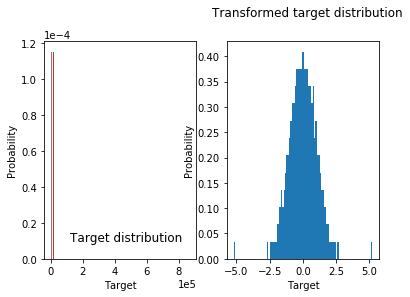

In [47]:
##transform y
from sklearn.preprocessing import QuantileTransformer, quantile_transform

y_trans = quantile_transform(y,
                             n_quantiles=900,
                             output_distribution='normal',
                             copy=True).squeeze()

##plot the density
density_param = {'density': True}
    
f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, **density_param)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.text(s='Target distribution', x=1.2e5, y=9.8e-6, fontsize=12)
ax0.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))


ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.text(s='Transformed target distribution', x=-6.8, y=0.479, fontsize=12)

In [120]:
# # ##use tranformed target regressor

# # prepare the model with target scaling
# # SVR_trans = TransformedTargetRegressor(regressor=SVR(), transformer=QuantileTransformer(n_quantiles=20, output_distribution='normal'))
# SVR_trans = TransformedTargetRegressor(regressor=SVR(),func=np.log1p,inverse_func=np.expm1)

# # ##define the cross validation
# # cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=1)
# cv = 3

# param_trans = {
#     "regressor__C": [1e0, 1e1, 1e2, 1e3],
#     "regressor__epsilon": np.logspace(-2, 2, 5),
#     "regressor__gamma": np.logspace(-2, 2, 5),
#     "regressor__kernel": ['linear', 'poly', 'rbf', 'sigmoid']
# }

# transModel = RandomizedSearchCV(SVR_trans, param_distributions = param_trans, n_iter= 1, scoring="neg_mean_absolute_error", n_jobs=-1, cv=cv, 
#                         random_state=1, verbose=3)


In [224]:
# ##use tranformed target regressor

SVR_trans = TransformedTargetRegressor(regressor=SVR(), transformer=QuantileTransformer(n_quantiles=900, output_distribution='normal'))

# ##define the cross validation
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=1)

# param_trans = {
#     "regressor__C": [1e0, 1e1],
#     "regressor__epsilon": np.logspace(-2, 2, 2),
#     "regressor__gamma": np.logspace(-2, 2, 2),
#     "regressor__kernel": ['linear', 'rbf']
# }
param_trans = {
    "regressor__C": [1e0, 1e1, 1e2, 1e3],
    "regressor__epsilon": np.logspace(-2, 2, 4),
    "regressor__gamma": np.logspace(-2, 2, 4),
    "regressor__kernel": ['linear', 'rbf']#, 'sigmoid']
}

transModel = GridSearchCV(SVR_trans, param_grid = param_trans, scoring="neg_mean_absolute_error", n_jobs=-1, cv=cv, verbose=3)

In [225]:
#conduct serach
svrtr_trans = transModel.fit(X_train, y_train.values.ravel())
# svrtr_trans = transModel.fit(X_train.iloc[:50, :], y_train[:50].values.ravel())
# summarize result
print('Best Score: %s' % svrtr_trans.best_score_)
print('Best Hyperparameters: %s' % svrtr_trans.best_params_)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  2.3min


Best Score: -9301.675369635503
Best Hyperparameters: {'regressor__C': 1000.0, 'regressor__epsilon': 0.21544346900318834, 'regressor__gamma': 0.01, 'regressor__kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed:  8.8min finished
/Users/ko-akande/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (900) is greater than the total number of samples (197). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


In [226]:
#train on all parameters
paramBest = svrtr_trans.best_params_
svr_best = SVR(C=paramBest['regressor__C'], kernel=paramBest['regressor__kernel'], 
               gamma=paramBest['regressor__gamma'], epsilon=paramBest['regressor__epsilon'])
svr_best.fit(X_train, y_train.values.ravel())

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.21544346900318834,
    gamma=0.01, kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

In [233]:
#save the model
import pickle

modeltransGS = "transformedModel.sav"
BestModelGS = "transformedBestModel.sav"
pickle.dump(svrtr_trans, open(modeltransGS, "wb"))
pickle.dump(svr_best, open(BestModelGS, "wb"))

In [227]:
# yrand = svr_best.predict(X_test)
yrand = svrtr_trans.predict(X_test)
RMSEopt = MSE(y_test.values, yrand, squared=False)

print("The optimised testing performance for transformed y is: ", RMSEopt)

The optimised testing performance for transformed y is:  10219.412289263011


In [229]:
#get r2 score
from sklearn.metrics import r2_score
r2opt = r2_score(y_test.values, yrand)

print("The optimised R2 for testing performance is: ", r2opt)

The optimised R2 for testing performance is:  0.8554127537116518


In [231]:
#get MAE
from sklearn.metrics import mean_absolute_error as MAE
MAEopt = MAE(y_test.values, yrand)

print("The optimised MAE for testing performance is: ", MAEopt)

The optimised MAE for testing performance is:  3680.0710375200715


In [ ]:
rmse = np.sqrt(((y_test.values - yrand) ** 2).mean())

print(rmse)

### References
[Solved the problem of nested estimator in GridSearchCV](1)
[https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier/12637528#12637528](https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier/12637528#12637528)